1
count    2000.000000
mean       -0.036500
std         0.976260
min        -2.813026
25%        -0.708194
50%        -0.047874
75%         0.626371
max         2.944269
dtype: float64
count    2000.000000
mean       -0.036000
std         0.985543
min        -3.013026
25%        -0.694290
50%        -0.053740
75%         0.647429
max         2.946284
dtype: float64


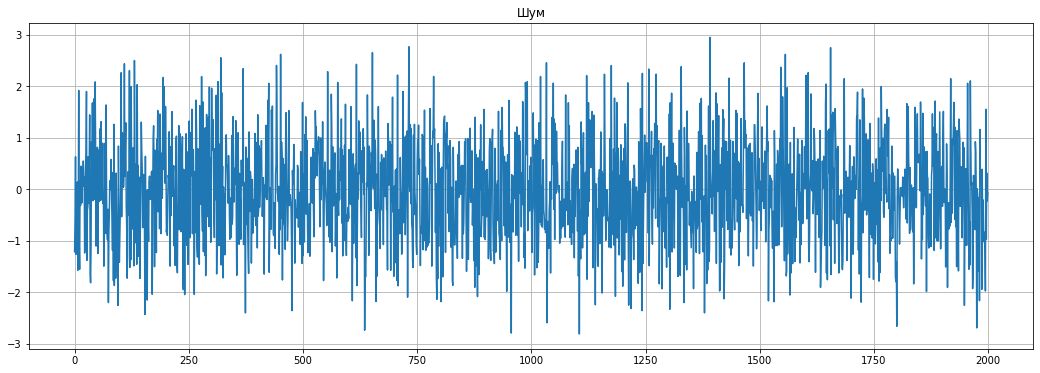

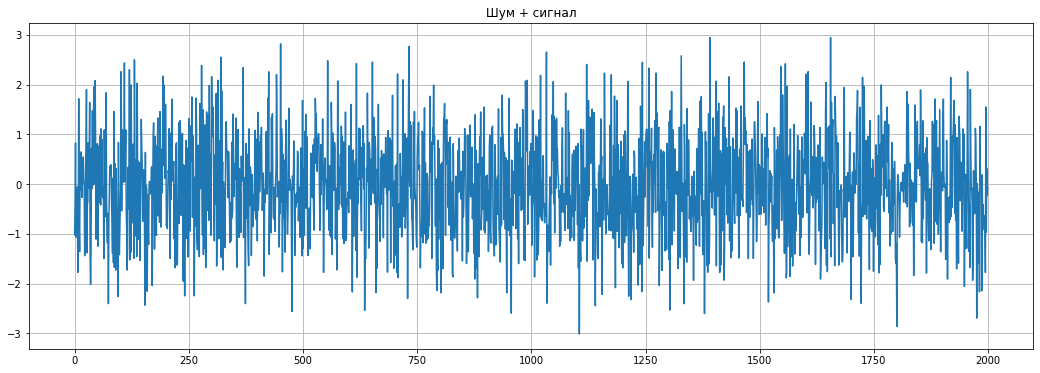

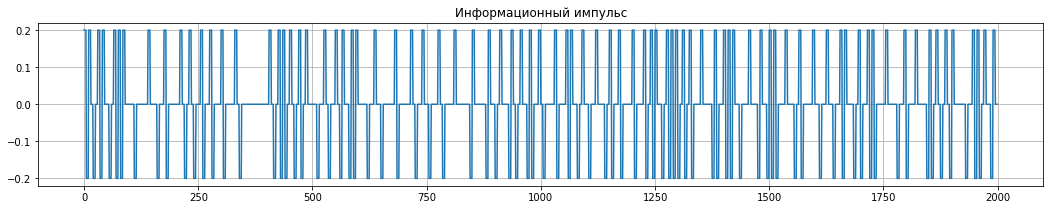

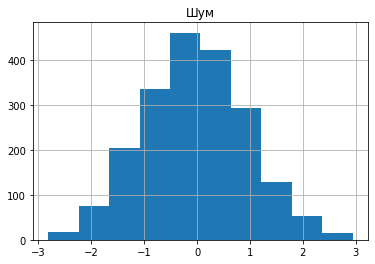

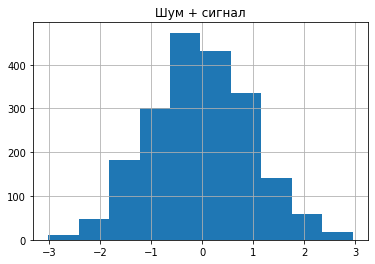

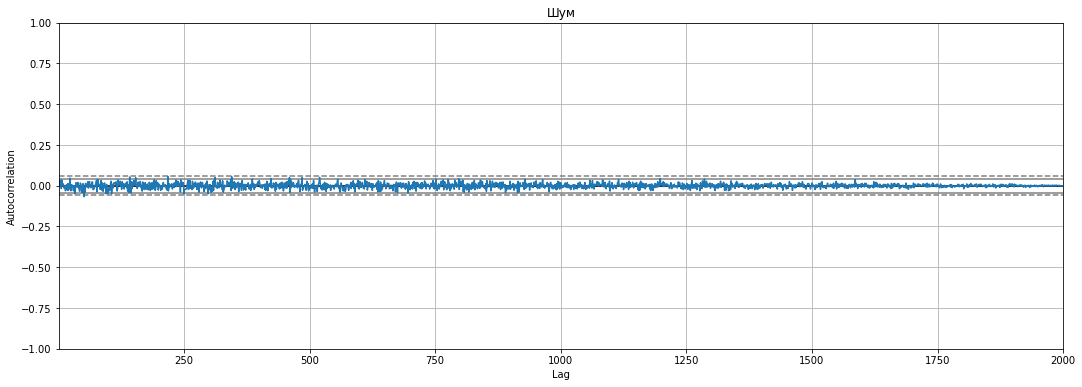

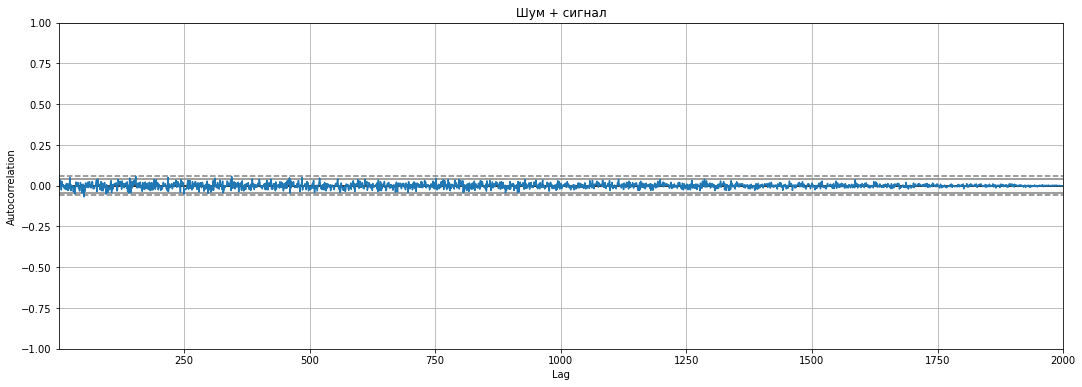

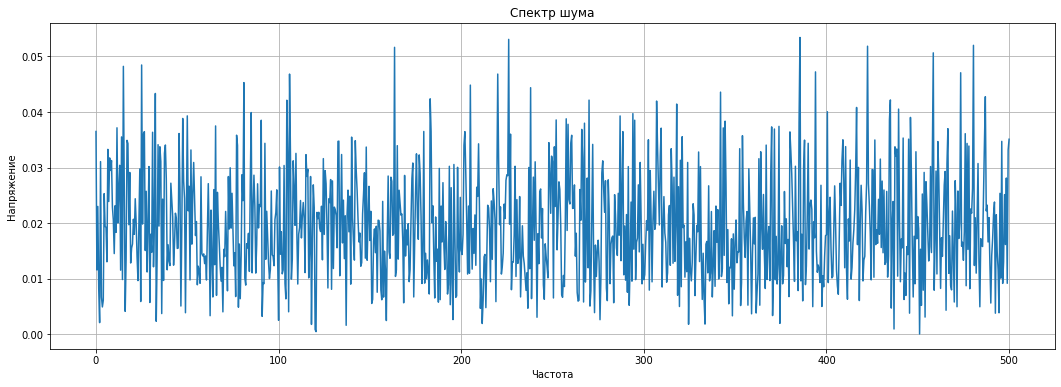

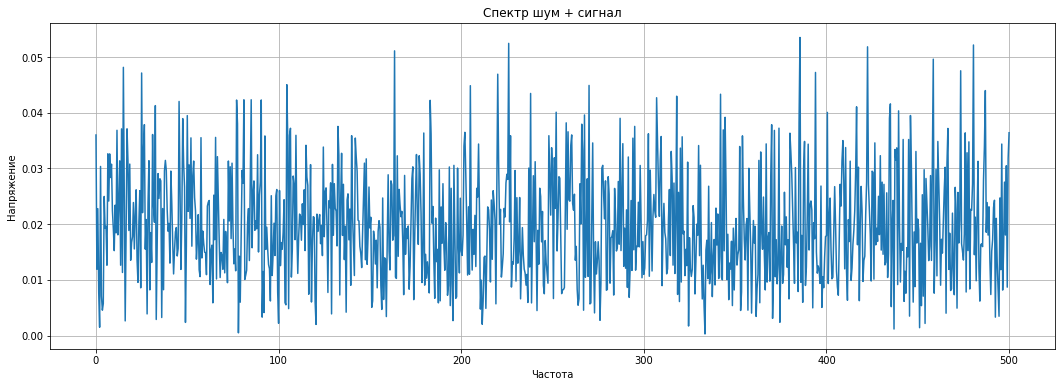

In [1]:
from random import gauss, randint, seed
from pandas import Series, plotting
from numpy import abs, fft
from matplotlib import pyplot as plt
 
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 100em; }</style>"))
 
# ограниченный гауссов шум
def noise(N, rms, bottom, top):      
    noise = []
    for _ in range(N):
        x = gauss(0, rms)
        while (bottom <= x <= top) == False:
            x = gauss(0, rms)
        noise.append(x)
    return noise       
 
# информационный импульс 
def random_pulse(a, n, t, T):         
    seed(1)
    randset = {randint(0, T/t) for i in range(n)}
    r_p = []
    sgn = 1   # знак малого импульса
    for i in range(int(T/t)):
        if i in randset:
            [r_p.append(sgn * a) for j in range(t)]
            sgn *= -1
        else:
            [r_p.append(0) for j in range(t)]
    return r_p       

# модуляция шума битовыми импульсами   
def add_mod(bits):                   
    signal = [] 
    for bit in bits:
        if bit == 1:
            [signal.append(i) for i in r_p]
        if bit == 0:
            [signal.append(0) for i in range(T)]
    return [x + y for x, y in zip(signal, noise)]
    
# извлечение бит из входного сигнала
def extract_info(sig, r_p, k):    
    ans = []
    while True:
        i, p = 0, 0
        while i < T:
            if r_p[i] > 0:
                p += sum(sig[i : i + t]) / t
            elif r_p[i] < 0:
                p -= sum(sig[i : i + t]) / t
            i += t
        ans.append(int(p > k * rms))
        if len(sig) == T: break
        sig = sig[T:]
    return ans
 
 
rms = 1                   # СКЗ шума
a = 0.2  #0.01            # амплитуда субимпульсов
n = 200  #50000           # количество субимпульсов
t = 5                     # длительность субимпульса
T = 2000 #500000          # длительность информармационного импульса r_p, T % t == 0 !!!
k = 20   #200             # коэффициент отсечки шума (по амплитуде)
 
 
s = '1'                   # передаваемая строка бит
#s = '0110100001100101011011000110110001101111' # Hello в UTF-8
 
N = T * len(s)       # длина сигнала и шума
 
#L = 10              # длина тестовой строки бит
#N = T * L           # длина тестового сигнала и шума
 
noise = noise(N, rms, -3, 3)
r_p = random_pulse(a, n, t, T)
 
sig = add_mod(list(map(int, s)))
 
ans = ''.join(map(str, extract_info(sig, r_p, k)))
print(ans)
assert ans == s
 
# проверка корректности модели при заданной L
def test(L, n):
    for _ in range(n):
        randlst = [randint(0, 1) for i in range(L)]
        sig = add_mod(randlst)
        assert extract_info(sig, r_p, k) == randlst
        return
#test(L, 10)

# Графическое отображение данных шума и шума с сигналом.

series = Series(noise)
series_2 = Series(r_p)
series_3 = Series(sig)
 
# summary stats
print(series.describe())
print(series_3.describe())
 
# line plot
series.plot(figsize=(18,6), grid=True)
plt.title(u'Шум')
plt.show()
 
series_3.plot(figsize=(18,6), grid=True)
plt.title(u'Шум + сигнал')
plt.show()
 
series_2.plot(figsize=(18,3), grid=True)
plt.title(u'Информационный импульс')
plt.show()
 
# histogram plot
series.hist()
plt.title(u'Шум')
plt.show()
 
series_3.hist()
plt.title(u'Шум + сигнал')
plt.show()
 
# autocorrelation
plt.figure(figsize=(18,6))
plotting.autocorrelation_plot(series)
plt.title(u'Шум')
plt.show()
 
plt.figure(figsize=(18,6))
plotting.autocorrelation_plot(series_3)
plt.title(u'Шум + сигнал')
plt.show()
 
# FFT
spectrum = fft.rfft(series)
spectrum_2 = fft.rfft(series_3)
 
FD = 1000  # частота дискретизации
 
plt.figure(figsize=(18,6))
plt.plot(fft.rfftfreq(N, 1./FD), abs(spectrum)/N)
plt.xlabel(u'Частота')
plt.ylabel(u'Напряжение')
plt.title(u'Спектр шума')
plt.grid(True)
plt.show()
 
plt.figure(figsize=(18,6))
plt.plot(fft.rfftfreq(N, 1./FD), abs(spectrum_2)/N)
plt.xlabel(u'Частота')
plt.ylabel(u'Напряжение')
plt.title(u'Спектр шум + сигнал')
plt.grid(True)
plt.show()

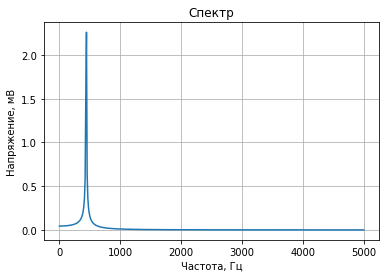

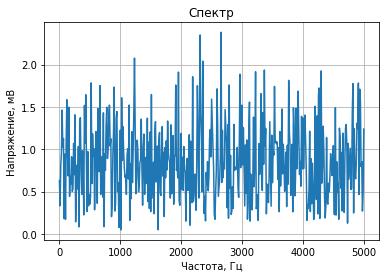

0.850745009097043


In [371]:
# БПФ синуса и случайного сигнала

from numpy import array, arange, abs as np_abs
from numpy.fft import rfft, rfftfreq
from math import sin, pi
from numpy.random import uniform
import matplotlib.pyplot as plt
from random import gauss
# а можно импортировать numpy и писать: numpy.fft.rfft

from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 50em; }</style>"))

FD = 10000 # частота дискретизации, отсчётов в секунду
# а это значит, что в дискретном сигнале представлены частоты от нуля до 5000 Гц (это и есть теорема Котельникова)
N = 900 # длина входного массива

pure_sin = array([6.*sin(2.*pi*440.0*t/FD) for t in range(N)])

noise = [gauss(0.0, 1) for i in range(N)]          # (ср.знач, ср.кв.знач.)

# сгенерируем шум, тоже длиной N (это важно!)
noise_2 = uniform(-50.,50., N)

# вычисляем преобразование Фурье. Сигнал действительный, поэтому надо использовать rfft, это быстрее, чем fft
spectrum = rfft(pure_sin)
spectrum_2 = rfft(noise_2)

# нарисуем всё это, используя matplotlib
plt.plot(rfftfreq(N, 1./FD), np_abs(spectrum)/N)
# rfftfreq сделает всю работу по преобразованию номеров элементов массива в герцы
# нас интересует только спектр амплитуд, поэтому используем abs из numpy (действует на массивы поэлементно)
# делим на число элементов, чтобы амплитуды были в милливольтах, а не в суммах Фурье. Проверить просто — постоянные составляющие должны совпадать в сгенерированном сигнале и в спектре
plt.xlabel(u'Частота, Гц')
plt.ylabel(u'Напряжение, мВ')
plt.title(u'Спектр')
plt.grid(True)
plt.show()

plt.plot(rfftfreq(N, 1./FD), np_abs(spectrum_2)/N)
# rfftfreq сделает всю работу по преобразованию номеров элементов массива в герцы
# нас интересует только спектр амплитуд, поэтому используем abs из numpy (действует на массивы поэлементно)
# делим на число элементов, чтобы амплитуды были в милливольтах, а не в суммах Фурье. Проверить просто — постоянные составляющие должны совпадать в сгенерированном сигнале и в спектре
plt.xlabel(u'Частота, Гц')
plt.ylabel(u'Напряжение, мВ')
plt.title(u'Спектр')
plt.grid(True)
plt.show()

print(sum(np_abs(spectrum_2)/N) / len(rfftfreq(N, 1./FD)))

In [146]:
randlst = [randint(0, 1) for i in range(10)]
print(randlst)

[0, 1, 0, 0, 1, 0, 1, 1, 1, 1]
